## Setup & Imports

Here we install the library, log into HF (you'll need to accept the licence terms to download the model) and import some things we'll need for the demos.

In [ ]:
!pip install transformers diffusers==0.2.4 # For now specific version needed as update broke something

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading the models

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.21.self_attn.q_proj.weight', 'vision_model.encoder.layers.23.self_attn.v_proj.bias', 'vision_model.encoder.layers.14.layer_norm2.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.k_proj.weight', 'vision_model.encoder.layers.20.self_attn.q_proj.weight', 'vision_model.encoder.layers.0.self_attn.out_proj.bias', 'vision_model.encoder.layers.9.self_attn.v_proj.bias', 'vision_model.encoder.layers.15.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.mlp.fc1.weight', 'vision_model.encoder.layers.16.layer_norm2.bias', 'vision_model.encoder.layers.8.mlp.fc1.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.bias', 'vision_model.encoder.layers.17.self_attn.v_proj.bias', 'vision_model.encoder.layers.22.mlp.fc1.weight', 'vision_m

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

0it [00:00, ?it/s]

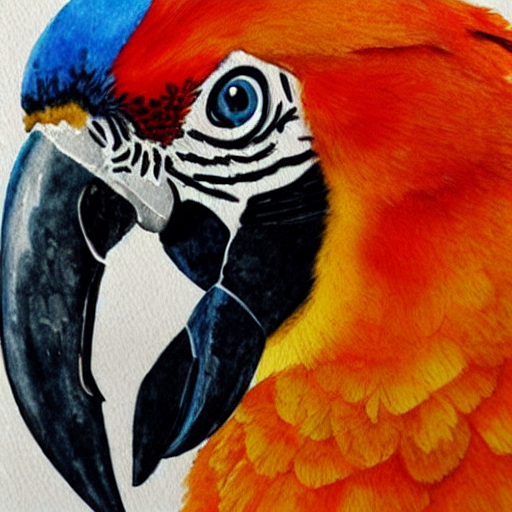

In [ ]:
# Some settings
prompt = ["A watercolor painting of a macaw"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents)

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

It works, but what does it all mean? Let's look at the different components here one by one.

## The AutoEncoder (AE)

The AE can 'encode' and image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [ ]:
# Using torchvision.transforms.ToTensor
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
    latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
  return 0.18215 * latent.mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

We'll use a pic from the web here, but you can load your own instead by uploading it and editing the filename in the following code.

In [ ]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0  58516      0  0:00:01  0:00:01 --:--:-- 58516


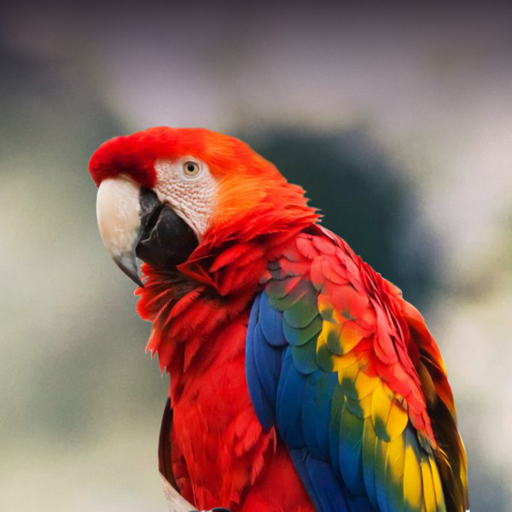

In [ ]:
# Load the image with PIL
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

Encoding this into the latent space of the AE with the finction defined above looks like this:

In [ ]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

We can do the reverse as well, going fom the latent representation back to an image:

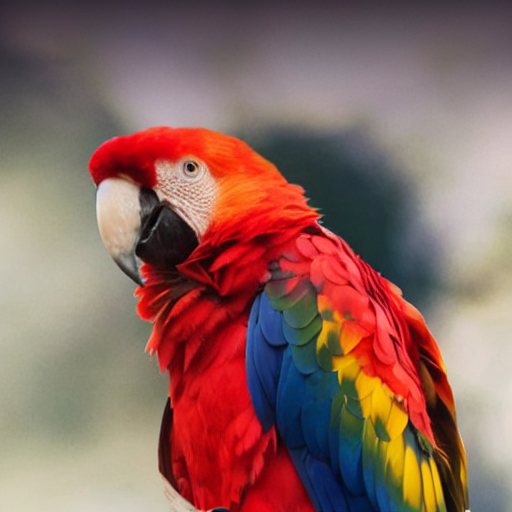

In [ ]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

In [ ]:
# Setting the number of sampling steps:
scheduler.set_timesteps(15)

You can see how our new set of steps corresponds to those used in training:

In [ ]:
# See these in terms of the original 1000 steps used for training:
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000], dtype=torch.float64)


And how much noise is present at each:

In [ ]:
# Look at the equivalent noise levels:
print(scheduler.sigmas)

tensor([14.6147,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000],
       dtype=torch.float64)


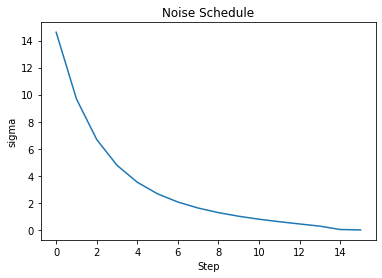

In [ ]:
#@markdown Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Step')
plt.ylabel('sigma')
plt.show()

This 'sigma' is the amount of noise added to the latent representation. Let's visualize what this looks like by adding a bit of noise to our encoded image and then decoding this noised version:

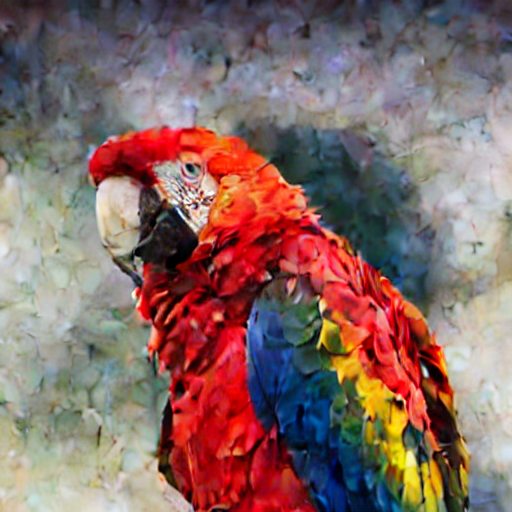

In [ ]:
# View a noised version
noise = torch.randn_like(encoded) # Random noise
timestep = 150 # i.e. equivalent to that at 150/1000 training steps
encoded_and_noised = scheduler.add_noise(encoded, noise, timestep)
latents_to_pil(encoded_and_noised)[0] # Display

What does this look like at t=300, 500 or 999? Try it out and see :)

0it [00:00, ?it/s]

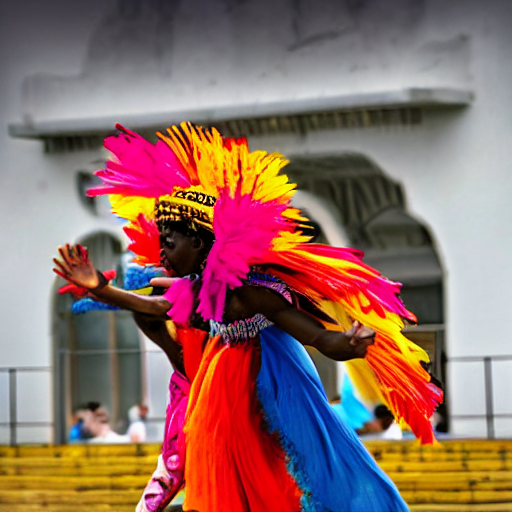

In [ ]:
#@title re-generate starting from a noised version of this image
prompt = ["A colorful dancer, nat geo photo"] #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Start step
start_step = 10 #@param Explore ;)
start_sigma = scheduler.sigmas[start_step]
start_timestep = int(scheduler.timesteps[start_step])

# Prep latents
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, start_timestep)
latents = latents.to(torch_device)
latents = latents * start_sigma  # << NB

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i > start_step:
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

In [ ]:
# Let's start with a prompt
prompt = 'Cave painting of a bird, flooble'

In [ ]:
# First step is to convert this into a sequence of tokens
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,  9654,  3086,   539,   320,  3329,   267,  4062,  1059, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [ ]:
# Decode the first non-special token
tokenizer.decoder.get(9654)

'cave</w>'

In [ ]:
# And the last two non-pad tokens:
print(4062, tokenizer.decoder.get(4062))
print(1059, tokenizer.decoder.get(1059))

4062 floo
1059 ble</w>


In [ ]:
# Grab the embeddings
embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', embeddings.shape)
embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.1967,  0.3905, -1.1450,  ..., -0.9653,  2.0285,  0.2323],
         [-0.1163,  0.4147, -1.2173,  ..., -0.6865, -0.3320,  1.5457],
         ...,
         [-0.3868, -0.0672, -0.0636,  ..., -1.5762,  0.1958, -0.1945],
         [-0.3894, -0.0515, -0.0919,  ..., -1.5772,  0.2131, -0.1897],
         [-0.3998, -0.0703,  0.0162,  ..., -1.5541,  0.2430, -0.1985]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

0it [00:00, ?it/s]

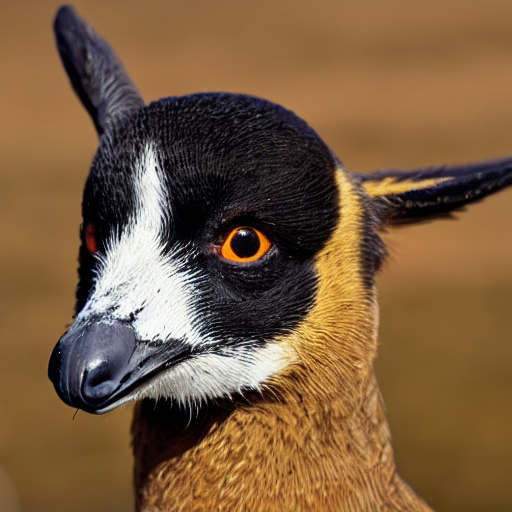

In [ ]:
#@title re-generate starting from a noised version of this image
prompt1 = 'A dog' #@param
prompt2 = 'A bird' #@param
mix_factor = 0.4 #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
# Embed both prompts
text_input1 = tokenizer([prompt1], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings1 = text_encoder(text_input1.input_ids.to(torch_device))[0]
text_input2 = tokenizer([prompt2], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings2 = text_encoder(text_input2.input_ids.to(torch_device))[0]
# Take the average
text_embeddings = (text_embeddings1*mix_factor + \
                   text_embeddings2*(1-mix_factor))
# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]